In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import scipy.ndimage 
import skimage.filters

In [57]:
imag=plt.imread('Dataset/xray.tif')

<h2 style="text-align: center;"><strong>Step 1: Generation of Masks</strong></h2>
 

In [58]:
def calculate_filter_size(T,sigma):
    
    sHalf=np.round(np.sqrt(-np.log(T)*2*sigma**2))
    size=2*sHalf+1
    return size

def calculate_gradiant(T=0.3,sigma=0.5):
    
    size=calculate_filter_size(T,sigma)
    size=size//2
    
    X,Y=np.mgrid[-size:size+1, -size:size+1]
   
    Gx= np.int16(np.round( -255*(1/(2*np.pi*sigma**2))*X*np.exp(-(X**2+Y**2)/(2*sigma**2)) ))
    Gy= np.int16(np.round( -255*(1/(2*np.pi*sigma**2))*Y*np.exp(-(X**2+Y**2)/(2*sigma**2)) ))
                                          
                          # Scale 
    
    return Gx,Gy
    

<h2 style="text-align: center;"><strong>Step 2: Applying Masks to Images, Compute gradient magnitude, Compute gradient Direction</strong></h2>

In [59]:
def apply_masks(img,Gx,Gy):
    
    img_shape= img.shape
    img_h=img_shape[0]
    img_w=img_shape[1]
    
    mask_shape = Gx.shape
    msk_h=mask_shape[0]
    msk_w=mask_shape[1]
    
    Fx= np.zeros( (img_h-msk_h+1 , img_w-msk_w+1) )
    Fy= np.zeros( (img_h-msk_h+1 , img_w-msk_w+1) )
    
    row_ind=range(img_h-msk_h+1)
    col_ind=range(img_w-msk_w+1)
    
    ############### Convolution with Gx filter ################
    
    for row in row_ind:
        for col in col_ind :
            Fx[row,col]= np.sum( np.multiply(  img[ row:(row+msk_h) , col:(col+msk_h)]  , Gx  ) )
            
    ############### Convolution with Gy filter ################
    
    for row in row_ind:
        for col in col_ind :
            Fy[row,col]= np.sum( np.multiply(  img[ row:(row+msk_h) , col:(col+msk_h)]  , Gy  ) )
    
    return  Fx,Fy

In [60]:
def compute_magnitude(Fx,Fy):
    M = np.sqrt(Fx**2 + Fy**2)
    return M

In [61]:
def compute_angle(Fx,Fy):
    theta = np.arctan2(Fy, Fx)
    return theta

<h2 style="text-align: center;"><strong>Step 3: Non-Maxima Supression</strong></h2>

In [68]:
def non_maximum_supression(M ,angles):
    
    M=255*(M/M.max())
    theta_deg= np.rad2deg(angle) + 180
    
    # Quantization of Gradient Direction
    
    quantized_dir = np.zeros(theta_deg.shape)
    
    quantized_dir[  ((theta_deg>=0)    & (theta_deg<22.5))  |  ((theta_deg>=157.5) & (theta_deg<202.5))  |  ((theta_deg>=337.5) & (theta_deg<=360  )) ] = 0
    
    
    quantized_dir[ ((theta_deg>=22.5)  & (theta_deg<67.5))  |  ((theta_deg>=202.5) & (theta_deg<247.5)) ] = 1
               
    
    quantized_dir[ ((theta_deg>=67.5)  & (theta_deg<112.5)) |  ((theta_deg>=247.5) & (theta_deg<292.5)) ] = 2
    
    
    quantized_dir[ ((theta_deg>=112.5) & (theta_deg<157.5)) |  ((theta_deg>=292.5) & (theta_deg<337.5)) ] = 3
    
    
    
    
    # Comparison of current pixel' value with that of neighbors' in the direction of gradient
    nms = np.zeros(M.shape)
    
    row_ind=range(nms.shape[0])
    col_ind=range(nms.shape[1])
    
    
    for row in row_ind:
        for col in col_ind:
            
            # Checking valid row and column indices for comparing current pixel with its neighbors
            if ((row-1) >= 0)  and ((col-1) >= 0) and ((row+1) < M.shape[0]) and  ((col+1) < M.shape[1])  :  
                
                
                # Based on gradient direction, neighbors of current pixel will be selected and compared with it. If current pixel's value is greater than or equal to its neighbors' values, it is retained in current location of output otherwise zero is placed there.
                
                if (quantized_dir[row,col]==0.0):
                    if (M[row,col]>= M[row,col+1]) and (M[row,col]>= M[row,col-1]):     # Neighbors (Right, Left)
                        nms[row,col]=M[row,col]

                        
                        
                if (quantized_dir[row,col]==1.0):
                    if (M[row,col]>= M[row-1,col-1]) and (M[row,col]>= M[row+1,col+1]): # Neighbors (Lower Right, Upper Left)
                        nms[row,col]=M[row,col]


                if (quantized_dir[row,col]==2.0):
                    if (M[row,col]>= M[row-1,col]) and (M[row,col]>= M[row+1,col]):     # Neighbors (Up, Down)
                        nms[row,col]=M[row,col]


                if (quantized_dir[row,col]==3.0):
                    if (M[row,col]>= M[row-1,col+1]) and (M[row,col]>= M[row+1,col-1]): # Neighbors (Upper Right, Lower Left)
                        nms[row,col]=M[row,col]                        
                        
    return quantized_dir , nms

<h2 style="text-align: center;"><strong>Step 4: Hysteresis Thresholding</strong></h2>

In [69]:
def Hysteresis(img, TH=60, TL=10):
    M, N = img.shape  
    C=np.copy(img)

    #  Make border pixel zero
    C[0, :]=0
    C[-1,:]=0
    C[:, 0]=0
    C[:,-1]=0
    strong=255
    C[C>TH]=255.0   # Make those pixels White[255] that are greater than upper threshold (Th)
    C[C<TL]=0.0 
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (C[i,j] >= TL and C[i,j] <= TH):
                try:
                    if ((C[i+1, j-1] == strong) or (C[i+1, j] == strong) or (C[i+1, j+1] == strong)
                        or (C[i, j-1] == strong) or (C[i, j+1] == strong)
                        or (C[i-1, j-1] == strong) or (C[i-1, j] == strong) or (C[i-1, j+1] == strong)):
                        C[i, j] = strong
                    else:
                        C[i, j] = 0
                except IndexError as e:
                    pass
    return C

<h2 style="text-align: center;"><strong>Results Section</strong></h2>

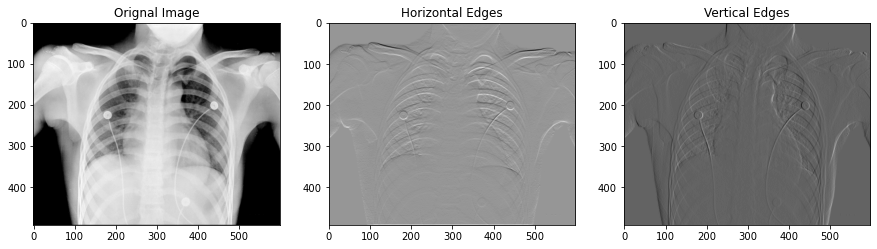

In [70]:
Gx,Gy=calculate_gradiant(0.3,0.5)
Fx,Fy=apply_masks(imag,Gx,Gy)


f = plt.figure(figsize=(15,15))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax.imshow(imag,cmap='gray')

ax.title.set_text('Orignal Image')
ax2.imshow(Fx,cmap='gray')
ax2.title.set_text('Horizontal Edges')
ax3.imshow(Fy,cmap='gray')

ax3.title.set_text('Vertical Edges')
plt.show()

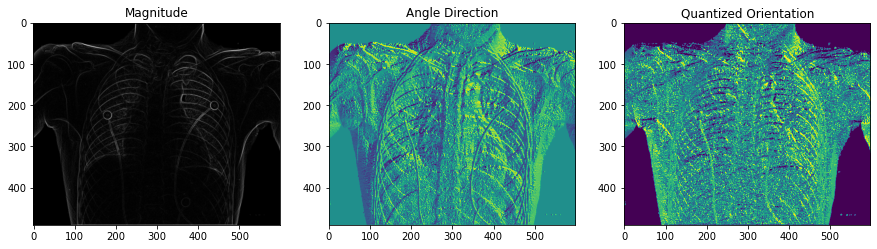

In [71]:
Magnitude=compute_magnitude(Fx,Fy)
angle=compute_angle(Fx,Fy)
Q,NMS=non_maximum_supression(Magnitude,angle)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax.imshow(Magnitude,cmap='gray')
ax.title.set_text('Magnitude')

ax2.imshow(angle)
ax2.title.set_text('Angle Direction')

ax3.imshow(Q)
ax3.title.set_text('Quantized Orientation')

plt.show()

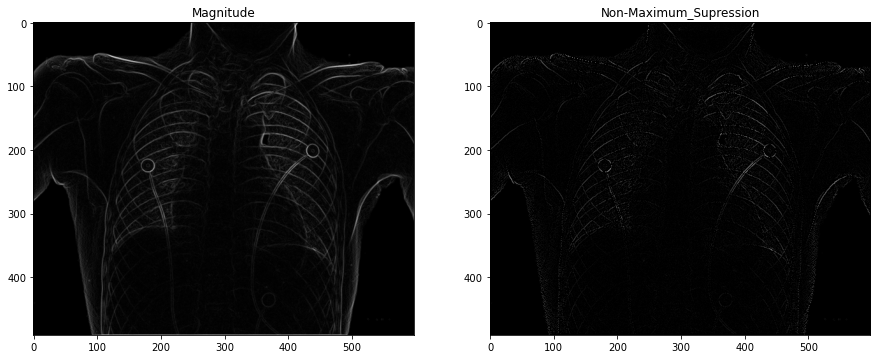

In [72]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


ax.imshow(Magnitude,cmap='gray')
ax.title.set_text('Magnitude')
ax2.imshow(NMS,cmap='gray')
ax2.title.set_text('Non-Maximum_Supression')

plt.show()

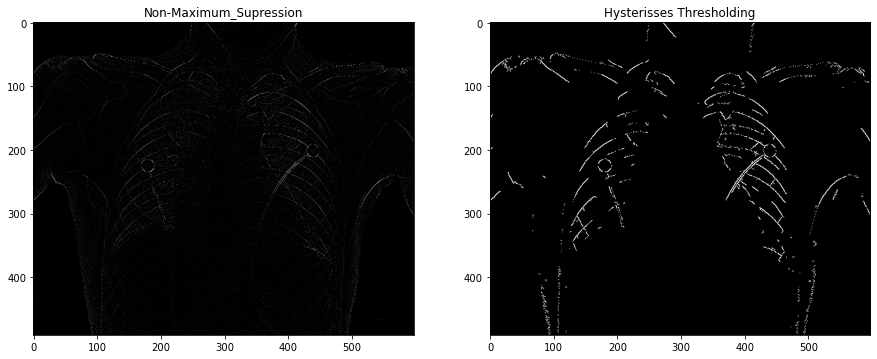

In [73]:
Final_edges=Hysteresis(NMS,TH=60,TL=15)
L= plt.figure(figsize=(15,15))
a1 = L.add_subplot(121)
b2 = L.add_subplot(122)
a1.imshow(NMS,cmap='gray')
a1.title.set_text('Non-Maximum_Supression')

b2.imshow(Final_edges,cmap='gray')
b2.title.set_text('Hysterisses Thresholding')

plt.show()

In [56]:
plt.imsave('road_fx_[1].jpg',Fx,cmap='gray')
plt.imsave('road_fy_[1].jpg',Fy,cmap='gray')
plt.imsave('road_magnitude_[1].jpg',Magnitude,cmap='gray')
plt.imsave('road_quantized_[1].jpg',Q,cmap='gray')
